# Introduction

This notebook contains the resulting model from the notebook Lesson#08's 2.3.3 section, in which we trained a model to predict wether the citizen had a income of >50k a year or <=50k a year. After tuning the model with GridSearchCV function, we exported a file with the best model achieved, named "data/pipe_final.pkl", and a dataframe with trainning information, such as accuracy, AUC value and other values.

First, let's import the data and the packages to make an analysis of the model.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#import pydotplus
from IPython.display import Image
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

results = pd.read_csv('data/result.csv')

class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]



class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  #Class constructor method that takes a boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.new_features:
      # Treat ? workclass as unknown
      df['workclass']= df['workclass'].replace('?','Unknown') 
      # Two many category level, convert just US and Non-US
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    
    #returns numpy array
    return df

file = open('data/pipe_final.pkl', 'rb')
best_model = pickle.load(file)
file.close()


results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__criterion,param_clf__random_state,param_clf__splitter,param_fs__k,...,split3_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0,0.154600,0.063468,0.106968,0.033366,"DecisionTreeClassifier(class_weight=None, crit...",gini,42.0,best,6.0,...,0.847512,0.850622,0.005825,81,0.865633,0.863278,0.859337,0.862817,0.862766,0.002250
1,1,0.147649,0.017496,0.074951,0.000437,"DecisionTreeClassifier(class_weight=None, crit...",gini,42.0,best,8.0,...,0.817568,0.819871,0.004811,120,0.929156,0.929515,0.929924,0.930590,0.929796,0.000533
2,2,0.211794,0.046755,0.088377,0.012706,"DecisionTreeClassifier(class_weight=None, crit...",gini,42.0,best,10.0,...,0.808507,0.814650,0.004307,122,0.964988,0.965704,0.966472,0.965960,0.965781,0.000535
3,3,0.160547,0.028693,0.128582,0.026086,"DecisionTreeClassifier(class_weight=None, crit...",gini,42.0,random,6.0,...,0.845209,0.849393,0.004837,94,0.865633,0.863278,0.859337,0.862817,0.862766,0.002250
4,4,0.115596,0.004341,0.078601,0.005739,"DecisionTreeClassifier(class_weight=None, crit...",gini,42.0,random,8.0,...,0.814650,0.820025,0.007099,119,0.929156,0.929515,0.929924,0.930590,0.929796,0.000533


## Importing census data

Before we move forward on feature analysis, let's import the data and check our chosen model the performance of it. 

In [19]:
income = pd.read_csv("data/income.csv")
income.head()
col = pd.Categorical(income.high_income)
income["high_income"] = col.codes
# global varibles
seed = 42
num_folds = 4
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

X_train, X_test, y_train, y_test = train_test_split(income.drop(labels="high_income",axis=1),
                                                    income["high_income"],
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=income["high_income"])

print(classification_report(y_test, best_model.predict(X_test), digits=4))

Train AUC score is: 0.9164
Test AUC score is 0.7814
Train accuracy score is: 0.8748
Test accuracy score is: 0.8664
              precision    recall  f1-score   support

           0     0.8863    0.9454    0.9149      4945
           1     0.7819    0.6173    0.6900      1568

    accuracy                         0.8664      6513
   macro avg     0.8341    0.7814    0.8024      6513
weighted avg     0.8611    0.8664    0.8607      6513



In [23]:
result_acc = results[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy']]
result_acc.sort_values(by='rank_test_Accuracy', ascending=True).head(10)

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
106,0.876600,0.001394,0.862561,0.004848,1
100,0.876587,0.001191,0.862254,0.005062,2
103,0.876715,0.001259,0.862101,0.004526,3
97,0.876625,0.001094,0.862062,0.005152,4
56,0.884969,0.001212,0.861870,0.002868,5
50,0.884969,0.000948,0.861870,0.002907,5
53,0.885250,0.001225,0.861755,0.002805,7
104,0.878378,0.001204,0.861717,0.003877,8
101,0.878494,0.001129,0.861678,0.003707,9
59,0.885186,0.001290,0.861602,0.002841,10


In [25]:
result_auc = results[['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC', 'rank_test_AUC']]
result_auc.sort_values(by='rank_test_AUC', ascending=True).head(10)

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
104,0.940975,0.000792,0.916398,0.002971,1
101,0.940970,0.000807,0.916378,0.002971,2
107,0.940973,0.000759,0.916369,0.002997,3
98,0.940757,0.000738,0.916196,0.003070,4
59,0.939745,0.000787,0.915977,0.003160,5
56,0.939763,0.000816,0.915967,0.003114,6
53,0.939774,0.000797,0.915955,0.003182,7
50,0.939608,0.000861,0.915839,0.003185,8
92,0.929276,0.000893,0.915343,0.003090,9
95,0.929299,0.000873,0.915323,0.003108,10


## Exploring scores of the model

The classification report tells us that the model had a overall accuracy of 86.64% on the test dataset, and also that the precision and recall had significantly lower values for class 1 than for class 0, which may indicate an imbalanced target class.

It is important to notice that what we chose as our best model had a higher AUC score than the rest of the models, which does not mean that it has the best accuracy, but, by knowing his index, we can see that it performed well in the accuracy test, being in the 8th position.

The model chosen had the following parameters:

In [27]:
best_model.best_params_

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=256,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=350,
                        n_jobs=None, oob_score=True, random_state=42, verbose=0,
                        warm_start=False),
 'clf__criterion': 'entropy',
 'clf__max_leaf_nodes': 256,
 'clf__n_estimators': 350,
 'clf__random_state': 42,
 'fs__k': 10,
 'fs__score_func': <function sklearn.feature_selection.univariate_selection.chi2(X, y)>}

It was a RandomForestClassifier that used the entropy criterion, with 256 maximum leaf nodes, 350 trees and used the 10 features with the higher chi2 score.

###  OOB Score
Another way to check the model's performance is by checking the out of bag score (OOB_score). This score is used in ensemble methods to check how it performed with data contained in the dataset that it had not been used for training, and give us a good estimate of our model's performance with unseen data, absolutely essential in machine learning competitions.

In our model, the OOB score was calculated with the accuracy metric. Let's check it out.

In [37]:
oob_score = best_model.best_estimator_['clf'].oob_score_
print(f'The OOB score is: {oob_score:.4f}')

The OOB score is: 0.8624


As we can see, the OOB score is of 86.24%, which was lower than our test accuracy score, altough it gave us a near value from it, which is 86.64%.

# Feature analysis

In this section, we will compare feature analysis methods. We will compare RandomForest's *feature_importance_* and the packages Skater and Eli5, in order to explore which features each method classify as important, and also compare how each of the methods evaluate these importances. After all, we will compare the results and check what characteristics were more important than the others.

## Feature importances

Now let's explore our best performant model and see feature importances:

In [89]:
mask = best_model.best_estimator_['fs'].get_support()
labels = X_train.columns[mask].to_list()

values = best_model.best_estimator_['clf'].feature_importances_
rfc = best_model.best_estimator_.fit(X_train, y_train)
rfc_fi = pd.Series(index=labels, data=values)
rfc_fi.sort_values(ascending=False)

education_num     0.194857
capital_loss      0.186252
fnlwgt            0.151451
capital_gain      0.147747
race              0.117028
native_country    0.063924
hours_per_week    0.050680
education         0.037788
workclass         0.036051
occupation        0.014221
dtype: float64

According to the *feature_importances_* attribute of the RandomForestClassifier of our best performant model, the *education_num* is the most important feature of the method, which is the education level of the citizen. Followed by this, we have *capital_loss*, *fnlwgt* (the number of people that the government estimates that one sample represents), *capital_gain*, *race* and so on. It is important to say that we feature engineered the native country to reduce cardinality to US's natives and foreigners.

Also, from *native_country* down to the last, we notice that the features had an importance lesser than 10%, meaning that they are not  much relevant for the model to classify the citizen's income. 

Another thing to ponctuate is the fact that we used sklearn's SelectKBest method to select the 10 features with higher chi2 score when compared to the target class, making us drop a few columns in our pipeline.

## ELI5

Now we're going to use ELI5 package to explore feature importances on our tuned model. In this method, we will explore the results for the four possible results: 
* the model classified income>50k and it actually had an income>50k
* the model classified income<=50k and it actually had an income<=50k
* the model classified income>50k and it actually had an income<=50k
* the model classified income<=50k and it actually had an income>50k

These four analysis are important in order to explore how and why the model predicted each citizen as it classified. But first, let's explore the global result feature importances.

In [109]:
# Creating preporcessing pipeline and transforming data do be able to use on ELI5

# Categrical features to pass down the categorical pipeline 
categorical_features = income.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = income.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer())
                                         ]
                                )
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_scaler', MinMaxScaler()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ]
                                           )
preprocessed_data = full_pipeline_preprocessing.fit_transform(X_train)
preprocessed_data[0, best_model.best_estimator_['fs'].get_support()]

array([9.        , 2.        , 4.        , 0.        , 1.        ,
       0.20547945, 0.8       , 0.        , 0.        , 0.44897959])

In [116]:
import eli5

doc_num = 1


print('Predicted Label:', rfc['clf'].predict(preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()].reshape(1,-1)))
print('Actual Label:', y_train[doc_num])
#eli5.show_prediction(best_model.best_estimator_['clf'], X_test.iloc[doc_num], 
#                     feature_names=labels,
#                     show_feature_values=True)

print
#print(rfc['clf'])
eli5.show_prediction(rfc['clf'], preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()], feature_names=labels, show_feature_values=True)

Predicted Label: [0]
Actual Label: 0


In [130]:
doc_num = 628

print('Predicted Label:', rfc['clf'].predict(preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()].reshape(1,-1)))
print('Actual Label:', y_train[doc_num])
#eli5.show_prediction(best_model.best_estimator_['clf'], X_test.iloc[doc_num], 
#                     feature_names=labels,
#                     show_feature_values=True)

print
#print(rfc['clf'])
eli5.show_prediction(rfc['clf'], preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()], feature_names=labels, show_feature_values=True)

Predicted Label: [0]
Actual Label: 1


In [164]:

doc_num=7
prediction = rfc['clf'].predict(preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()].reshape(1,-1))
print('Predicted Label:', prediction)
print('Actual Label:', y_train[doc_num])
#eli5.show_prediction(best_model.best_estimator_['clf'], X_test.iloc[doc_num], 
#                     feature_names=labels,
#                     show_feature_values=True)


#print(rfc['clf'])
point = preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()]
eli5.show_prediction(rfc['clf'], point, feature_names=labels, show_feature_values=True)

Predicted Label: [1]
Actual Label: 1


In [179]:
doc_num=18
prediction = rfc['clf'].predict(preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()].reshape(1,-1))
print('Predicted Label:', prediction)
print('Actual Label:', y_train[doc_num])
#eli5.show_prediction(best_model.best_estimator_['clf'], X_test.iloc[doc_num], 
#                     feature_names=labels,
#                     show_feature_values=True)


#print(rfc['clf'])
point = preprocessed_data[doc_num, best_model.best_estimator_['fs'].get_support()]
eli5.show_prediction(rfc['clf'], point, feature_names=labels, show_feature_values=True, target_names=['50k', '>50k'])

Predicted Label: [1]
Actual Label: 0


## Skater

Skater is a model interpretator which can do a global feature analysis. This means that, instead of weighthing the impact of each variable used in a model for each possible result,it does similar to the features importance on ensemble tree methods, and gives us metrics of how features influenced our result in a general way. Let's analyse the results.

(26048, 14)


2019-10-02 18:28:15,053 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[10/10] features ████████████████████ Time elapsed: 20 seconds

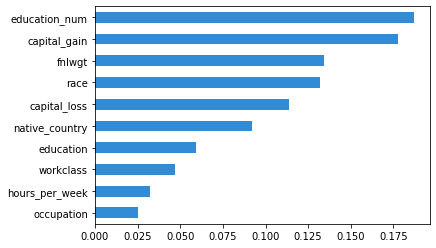

In [191]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
print(preprocessed_data.shape)
interpreter = Interpretation(training_data=preprocessed_data[:, mask], training_labels=y_train, 
                             feature_names=labels)
im_model = InMemoryModel(rfc['clf'].predict_proba, examples=preprocessed_data[:, mask], 
                         target_names=['$50K or less', 'More than $50K'])
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
                                                               n_samples=23000)